This notebook tries to answare this:
 
**2. How are YouTube channels interconnected, and what does this connectivity indicate about their influence and reach?**

**This part is only for the gaming category**


**Network Analysis within Gaming Category:**

We plan to identify key influencers and collaboration patterns in the Gaming category. The objective is to construct a network graph representing channels as nodes and collaborations as edges.
Then we will determine centrality measures to identify influential channels and analyze the frequency and scope of collaborations. To identify influential nodes and sub-networks in the games category we can use graph-theoretic measures (Louvain Community Detection). Visualization can be done through the application of NetworkX.

Sources: 
- https://memgraph.com/blog/community-detection-algorithms-with-python-networkx
- https://towardsdatascience.com/community-detection-algorithms-9bd8951e7dae


In [1]:
#Import 
import gzip
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from itertools import product
import re
import seaborn as sns
import scipy.stats as stats
import os

# regression / matching
import statsmodels.formula.api as smf
import networkx as nx
from collections import defaultdict

In [2]:
!pip install python-louvain

In [3]:
import matplotlib.cm as cm
from operator import itemgetter
import itertools

import warnings
warnings.filterwarnings('ignore')

In [4]:
import collections
from community import community_louvain

In [33]:
import operator
import random

**From milestone 2** We have 18.73 percent of rows where the collaborator ID is not NaN. This means that 18.73% of the videos that is published within the period has a collaborator within. We will now go into detail on the network of these collaborators. 

In [10]:
#Define configuration-related variables 
DEFAULT_ENCODING = 'UTF8'
# Read in data
def read_csv(file, chunk_size=30000): 
    file_path = os.path.join("C:\\Users\\Bruker\\ADA_project\\", file)
    chunk_list = []  # List to hold chunks
    for chunk in pd.read_csv(file_path, encoding=DEFAULT_ENCODING, chunksize=chunk_size):
        chunk_list.append(chunk)
    # Concatenate chunks into single DataFrame, if the csv had been close to the ram, it would be clever to put it in the loop. 
    df = pd.concat(chunk_list, ignore_index=True)
    return df
df_collab_per_week = read_csv('collaborators_per_week.csv')
df_collab_per_week.copy()
display(df_collab_per_week)

,Year-Week,channel_id,collaborators_in_week
0,2016-00,UC-0Wg1wOUp-bRF1ZiC0dE8g,NaN
1,2016-00,UC-1pADhAUignVbTbVCW4Uuw,['UChm3iPolG6IVrIQ3bc6bIuQ' 'UCYFn32jjeY0Rx6jx...
2,2016-00,UC-3Oc4KY7pElZMbsWtm3X6A,NaN
3,2016-00,UC-3wJqf60YbC6jzAfPRm2ig,NaN
4,2016-00,UC-46hTnlyW3aCwjHs2acDzg,[None 'ARLNoble' 'xMattyG1' 'tiametmarduk1']
...,...,...,...
1872846,2019-42,UCoaHAPh8BecD4qjwmuE96aw,UC0p1OMeCD9OPNmIWCfqdJ7w
1872847,2019-43,UCoaHAPh8BecD4qjwmuE96aw,UC0p1OMeCD9OPNmIWCfqdJ7w
1872848,2019-44,UCRIxiOJN0Xd3evqxRu4iXew,['albertsunzheng' 'MrCasping']
1872849,2019-44,UCoaHAPh8BecD4qjwmuE96aw,UC0p1OMeCD9OPNmIWCfqdJ7w


In [13]:
#Remove all with a Nan in collaborators, so cut out the weeks where a channel did not have a collaborator
df_collab_per_week_nonNAN = df_collab_per_week.dropna(subset=['collaborators_in_week'])

# Step 1: Data Cleaning and Transformation
def clean_and_extract_ids(row):
    # Implement the cleaning and extraction logic here
    # Return a list of channel IDs
    list_channel_ids = []
    try:
        cleaned_row = row.replace("[", "").replace("]", "").replace("'", "").replace("\n", " ").replace("None", "")
        ids = cleaned_row.split()  # This splits the string on spaces
        for id in ids:
            list_channel_ids.append(id)
    except Exception as e:
        print(f"Error processing row: {row}. Error: {e}")
    return list_channel_ids


# Apply the function to each row and create a new column for extracted IDs
df_collab_per_week_nonNAN['extracted_collaborators'] = df_collab_per_week_nonNAN['collaborators_in_week'].apply(clean_and_extract_ids)

display(df_collab_per_week_nonNAN)


,Year-Week,channel_id,collaborators_in_week,extracted_collaborators
1,2016-00,UC-1pADhAUignVbTbVCW4Uuw,['UChm3iPolG6IVrIQ3bc6bIuQ' 'UCYFn32jjeY0Rx6jx...,"[UChm3iPolG6IVrIQ3bc6bIuQ, UCYFn32jjeY0Rx6jxd_..."
4,2016-00,UC-46hTnlyW3aCwjHs2acDzg,[None 'ARLNoble' 'xMattyG1' 'tiametmarduk1'],"[ARLNoble, xMattyG1, tiametmarduk1]"
7,2016-00,UC-AVK_NtJg6aSYAeEbYnfIw,theDarkElfX,[theDarkElfX]
8,2016-00,UC-BG8jc9gI_BpobNXldQuFw,['morachi24' 'BSquaredHD'],"[morachi24, BSquaredHD]"
18,2016-00,UC-WA0qTCwuMCd418q_6xbEg,krypto9095,[krypto9095]
...,...,...,...,...
1872846,2019-42,UCoaHAPh8BecD4qjwmuE96aw,UC0p1OMeCD9OPNmIWCfqdJ7w,[UC0p1OMeCD9OPNmIWCfqdJ7w]
1872847,2019-43,UCoaHAPh8BecD4qjwmuE96aw,UC0p1OMeCD9OPNmIWCfqdJ7w,[UC0p1OMeCD9OPNmIWCfqdJ7w]
1872848,2019-44,UCRIxiOJN0Xd3evqxRu4iXew,['albertsunzheng' 'MrCasping'],"[albertsunzheng, MrCasping]"
1872849,2019-44,UCoaHAPh8BecD4qjwmuE96aw,UC0p1OMeCD9OPNmIWCfqdJ7w,[UC0p1OMeCD9OPNmIWCfqdJ7w]


In [15]:
#We saw that some people listed the same channels 150 times, in the same week, this gives a unreal distribution of our network
#If he not made that much videos in that week. 
#Example
print(df_collab_per_week_nonNAN_index_reset.iloc[1854].loc['extracted_collaborators'])


def remove_duplicates(collab_list):
    """
    Return a list with only unique items.
    """
    return list(set(collab_list))

#Rest index
df_collab_per_week_nonNAN_index_reset = df_collab_per_week_nonNAN.reset_index()

# Apply the function to the 'extracted_collaborators' column
df_collab_per_week_nonNAN_index_reset['unique_collaborators'] = df_collab_per_week_nonNAN_index_reset['extracted_collaborators'].apply(remove_duplicates)


display(df_collab_per_week_nonNAN_index_reset[df_collab_per_week_nonNAN_index_reset['channel_id']=='UCgc8PshAGngxCLCMfoy8NpQ'])

['PlayscopeHD', 'PlayscopeTimeline', 'playscopemobile', 'PlayscopeHD', 'PlayscopeTimeline', 'playscopemobile', 'PlayscopeHD', 'PlayscopeTimeline', 'playscopemobile', 'PlayscopeHD', 'PlayscopeTimeline', 'playscopemobile', 'PlayscopeHD', 'PlayscopeTimeline', 'playscopemobile', 'PlayscopeHD', 'PlayscopeTimeline', 'playscopemobile', 'PlayscopeHD', 'PlayscopeTimeline', 'playscopemobile', 'PlayscopeHD', 'PlayscopeTimeline', 'playscopemobile', 'PlayscopeHD', 'PlayscopeTimeline', 'playscopemobile', 'PlayscopeHD', 'PlayscopeTimeline', 'playscopemobile', 'PlayscopeHD', 'PlayscopeTimeline', 'playscopemobile', 'PlayscopeHD', 'PlayscopeTimeline', 'playscopemobile', 'PlayscopeHD', 'PlayscopeTimeline', 'playscopemobile', 'PlayscopeHD', 'PlayscopeTimeline', 'playscopemobile', 'PlayscopeHD', 'PlayscopeTimeline', 'playscopemobile', 'PlayscopeHD', 'PlayscopeTimeline', 'playscopemobile', 'PlayscopeHD', 'PlayscopeTimeline', 'playscopemobile', 'PlayscopeHD', 'PlayscopeTimeline', 'playscopemobile', 'Playscop

,index,Year-Week,channel_id,collaborators_in_week,extracted_collaborators,unique_collaborators
1854,6752,2016-01,UCgc8PshAGngxCLCMfoy8NpQ,['PlayscopeHD' 'PlayscopeTimeline' 'playscopem...,"[PlayscopeHD, PlayscopeTimeline, playscopemobi...","[playscopemobile, PlayscopeHD, PlayscopeTimeline]"
3594,12880,2016-02,UCgc8PshAGngxCLCMfoy8NpQ,['PlayscopeHD' 'PlayscopeTimeline' 'playscopem...,"[PlayscopeHD, PlayscopeTimeline, playscopemobi...","[playscopemobile, PlayscopeHD, PlayscopeTimeline]"
5388,19138,2016-03,UCgc8PshAGngxCLCMfoy8NpQ,['PlayscopeHD' 'PlayscopeTimeline' 'playscopem...,"[PlayscopeHD, PlayscopeTimeline, playscopemobi...","[playscopemobile, PlayscopeHD, PlayscopeTimeline]"
7199,25472,2016-04,UCgc8PshAGngxCLCMfoy8NpQ,['PlayscopeHD' 'PlayscopeTimeline' 'playscopem...,"[PlayscopeHD, PlayscopeTimeline, playscopemobi...","[playscopemobile, PlayscopeHD, PlayscopeTimeline]"
9031,31841,2016-05,UCgc8PshAGngxCLCMfoy8NpQ,['PlayscopeHD' 'PlayscopeTimeline' 'playscopem...,"[PlayscopeHD, PlayscopeTimeline, playscopemobi...","[playscopemobile, PlayscopeHD, PlayscopeTimeline]"
...,...,...,...,...,...,...
459852,1829452,2019-35,UCgc8PshAGngxCLCMfoy8NpQ,['PlayscopeTrailers' 'PlayscopeTrailers' 'Play...,"[PlayscopeTrailers, PlayscopeTrailers, Playsco...",[PlayscopeTrailers]
462317,1840028,2019-36,UCgc8PshAGngxCLCMfoy8NpQ,['PlayscopeTrailers' 'PlayscopeTrailers' 'Play...,"[PlayscopeTrailers, PlayscopeTrailers, Playsco...",[PlayscopeTrailers]
464771,1850573,2019-37,UCgc8PshAGngxCLCMfoy8NpQ,['PlayscopeTrailers' 'PlayscopeTrailers' 'Play...,"[PlayscopeTrailers, PlayscopeTrailers, Playsco...",[PlayscopeTrailers]
467230,1861124,2019-38,UCgc8PshAGngxCLCMfoy8NpQ,['PlayscopeTrailers' 'PlayscopeTrailers' 'Play...,"[PlayscopeTrailers, PlayscopeTrailers, Playsco...",[PlayscopeTrailers]


In [17]:
#Find channels with most unique collaborations: 
df_collab_per_week_nonNAN_index_reset['num_collaborators'] = df_collab_per_week_nonNAN_index_reset['unique_collaborators'].apply(len)
# Group by 'channel_id' and sum the 'num_collaborators' for each unique channel
aggregated_collaborators_df = df_collab_per_week_nonNAN_index_reset.groupby('channel_id')['num_collaborators'].sum().reset_index()

# Rename the summed column to 'total_collaborators'
aggregated_collaborators_df.rename(columns={'num_collaborators': 'total_collaborators'}, inplace=True)
aggregated_collaborators_df.sort_values(by = 'total_collaborators',ascending=False).head(10)

,channel_id,total_collaborators
3556,UCBw-Dz6wHRkxiXKCLoWqDzA,13291
5504,UCIciwR-CmXsaunrGw2DBjhA,5904
17519,UCxTjqtGRSkfhfnLp52ggcrA,4209
14892,UCo5fwkuD4XQi33vIpbi886w,3230
13289,UCimN5mkyHUmO3oQsU7c4uYQ,2687
5158,UCHSI8erNrN6hs3sUK6oONLA,2632
2031,UC6LYaCnVf9l-kIuVg2pPTHg,2433
17030,UCvaCEaGOHviqTIxzYKpcSLg,2394
1004,UC2_LJGtXaD9B8hsmXLj4IRw,2243
18254,UCzz9_nzdbrxnErTZPZdZ-cw,2215


count    18259.000000
mean        64.209376
std        193.155513
min          1.000000
25%          3.000000
50%         12.000000
75%         53.000000
max      13291.000000
Name: total_collaborators, dtype: float64


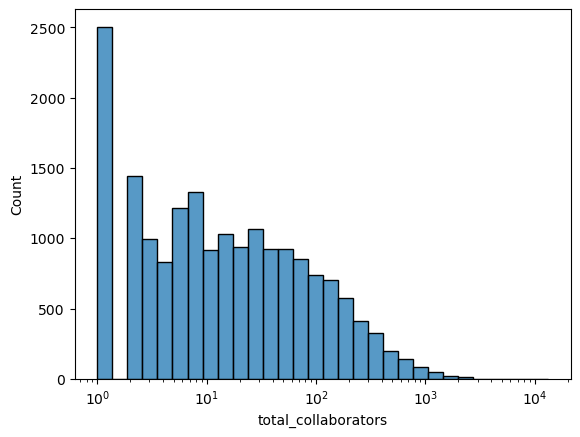

In [18]:
#The distribution of collaborators: 
print(aggregated_collaborators_df['total_collaborators'].describe())

# Histogram with adjusted bins and log scale
sns.histplot(aggregated_collaborators_df, x="total_collaborators", bins=30, log_scale=True)
plt.show()

**Making the network** 
1) Make the edge list
2) Assigne a network, but our edgelist is so big so we need to bootstrap the edge list

In [19]:
# Function to create edges from a row
def create_edges(row):
    return list(product([row['channel_id']], row['unique_collaborators']))

chunk_size = 5000
edges = []

for start in range(0, len(df_collab_per_week_nonNAN_index_reset), chunk_size):
    chunk = df_collab_per_week_nonNAN_index_reset.iloc[start:start + chunk_size]
    chunk_edges = chunk.apply(create_edges, axis=1).explode().tolist()
    edges.extend(chunk_edges)

print(edges[:10])
print(np.shape(edges))

[('UC-1pADhAUignVbTbVCW4Uuw', 'UCj8pJC0ONCz5zClAewsbSOw'), ('UC-1pADhAUignVbTbVCW4Uuw', 'UCYFn32jjeY0Rx6jxd_b_QQA'), ('UC-1pADhAUignVbTbVCW4Uuw', 'UChm3iPolG6IVrIQ3bc6bIuQ'), ('UC-46hTnlyW3aCwjHs2acDzg', 'tiametmarduk1'), ('UC-46hTnlyW3aCwjHs2acDzg', 'xMattyG1'), ('UC-46hTnlyW3aCwjHs2acDzg', 'ARLNoble'), ('UC-AVK_NtJg6aSYAeEbYnfIw', 'theDarkElfX'), ('UC-BG8jc9gI_BpobNXldQuFw', 'BSquaredHD'), ('UC-BG8jc9gI_BpobNXldQuFw', 'morachi24'), ('UC-WA0qTCwuMCd418q_6xbEg', 'krypto9095')]
(1172399, 2)


In [37]:
#Helper function from excersice 11: 
# Helper function for plotting the degree distribution of a Graph
# def plot_degree_distribution(G):
#     degrees = {}
#     for node in G.nodes():
#         degree = G.degree(node)
#         if degree not in degrees:
#             degrees[degree] = 0
#         degrees[degree] += 1
#     sorted_degree = sorted(degrees.items())
#     deg = [k for (k,v) in sorted_degree]
#     cnt = [v for (k,v) in sorted_degree]
#     fig, ax = plt.subplots()
#     plt.bar(deg, cnt, width=0.80, color='b')
#     plt.title("Degree Distribution")
#     plt.ylabel("Frequency")
#     plt.xlabel("Degree")
#     ax.set_xticks([d+0.05 for d in deg])
#     ax.set_xticklabels(deg)
#Redone with log-log: 
def plot_log_log_degree_distribution(G):
    degrees = {}
    for node in G.nodes():
        degree = G.degree(node)
        if degree not in degrees and degree > 0:  # Exclude zero-degree nodes
            degrees[degree] = 0
        degrees[degree] += 1
    sorted_degree = sorted(degrees.items())
    deg = [k for (k, v) in sorted_degree]
    cnt = [v for (k, v) in sorted_degree]

    fig, ax = plt.subplots()
    plt.bar(deg, cnt, color='b')  # Use scatter plot for clarity
    plt.title("Degree Distribution (Log-Log scale)")
    plt.ylabel("Frequency")
    plt.xlabel("Number of collaborators")
    plt.xscale('log')
    plt.yscale('log')

    plt.show()

# Helper function for printing various graph properties
def describe_graph(G):
    print(G)
    if nx.is_connected(G):
        print("Avg. Shortest Path Length: %.4f" %nx.average_shortest_path_length(G))
        print("Diameter: %.4f" %nx.diameter(G)) # Longest shortest path
    else:
        print("Graph is not connected")
        print("Diameter and Avg shortest path length are not defined!")
    print("Sparsity: %.4f" %nx.density(G))  # #edges/#edges-complete-graph
    # #closed-triplets(3*#triangles)/#all-triplets
    print("Global clustering coefficient aka Transitivity: %.4f" %nx.transitivity(G))
    print(f"Average degree: {sum(dict(G.degree()).values()) / float(G.number_of_nodes()):.4f}")

# Helper function for visualizing the graph
def visualize_graph(G, with_labels=True, k=None, alpha=1.0, node_shape='o'):
    #nx.draw_spring(G, with_labels=with_labels, alpha = alpha)
    pos = nx.spring_layout(G, k=k)
    if with_labels:
        lab = nx.draw_networkx_labels(G, pos, labels=dict([(n, n) for n in G.nodes()]))
    ec = nx.draw_networkx_edges(G, pos, alpha=alpha)
    nc = nx.draw_networkx_nodes(G, pos, nodelist=G.nodes(), node_color='g', node_shape=node_shape)
    plt.axis('off')

In [31]:
G = nx.Graph()
G.add_edges_from(edges)
describe_graph(G)

Graph with 201936 nodes and 297276 edges
Graph is not connected
Diameter and Avg shortest path length are not defined!
Sparsity: 0.0000
Global clustering coefficient aka Transitivity: 0.0021
Average degree: 2.9443


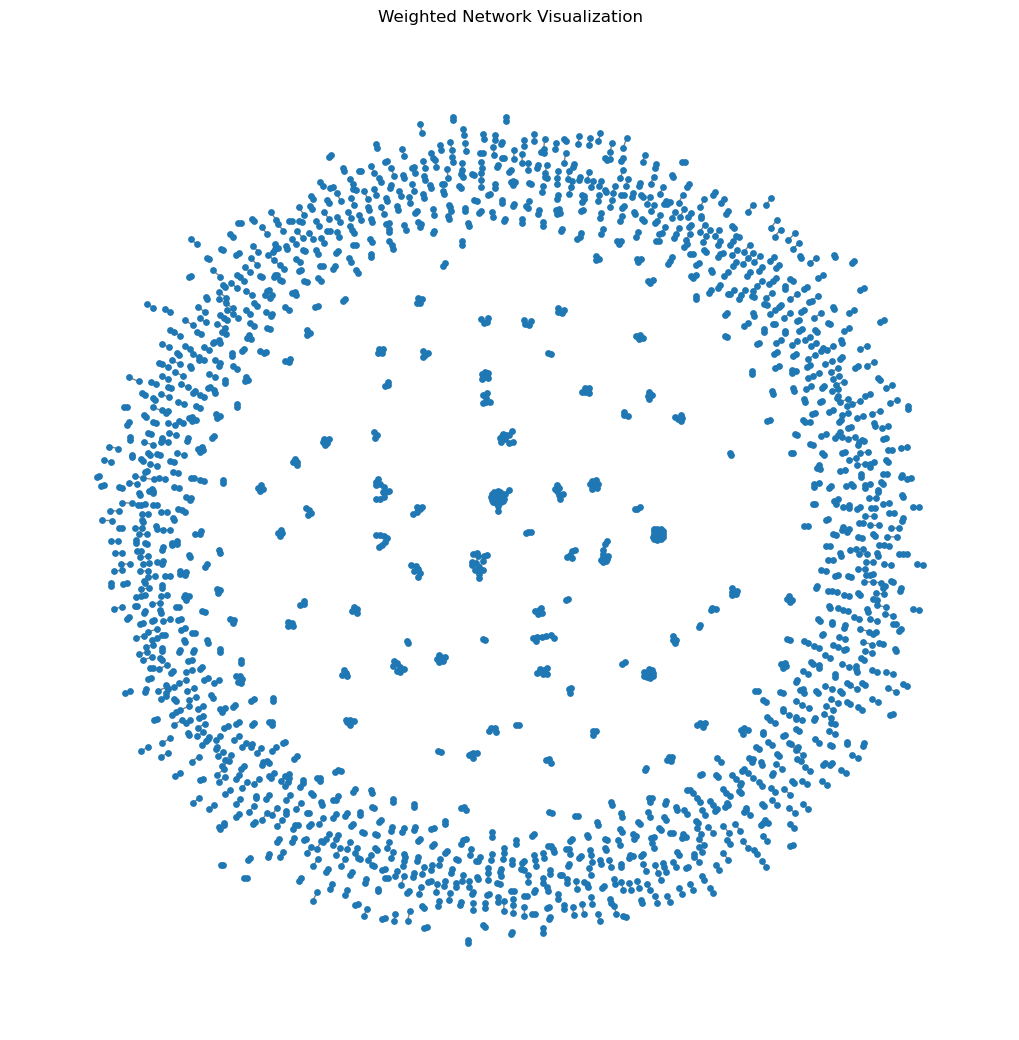

In [35]:
sampled_edges = random.sample(edges, 1500)

# Create a weighted graph
G_weighted = nx.Graph()

# Adding edges and counting the weight (number of occurrences)
for edge in sampled_edges:
    if G_weighted.has_edge(*edge):
        G_weighted[edge[0]][edge[1]]['weight'] += 1
    else:
        G_weighted.add_edge(*edge, weight=1)

# Extract weights from the graph
weights = [G_weighted[u][v]['weight'] for u, v in G_weighted.edges()]

# Visualize the graph with edge widths based on weights
plt.figure(figsize=(10, 10))
nx.draw(G_weighted, node_size=15, width=weights, edge_color="gray", with_labels=False)
plt.title("Weighted Network Visualization")
plt.show()

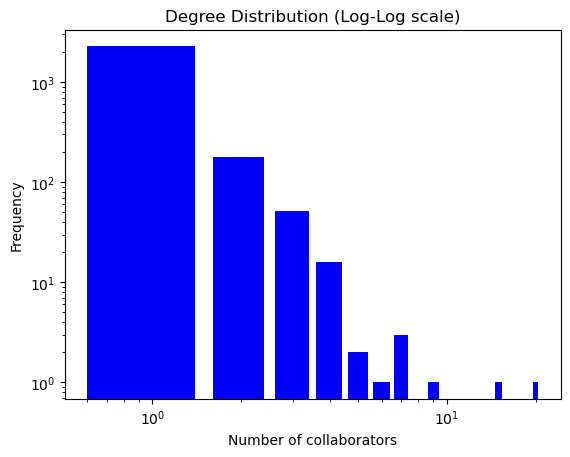

In [39]:
plot_log_log_degree_distribution(G_weighted)
#Some work can be done so it is even, but not important

In [40]:
#From excersice 11: 
print("Network sparsity: %.4f" %nx.density(G_weighted))
print(nx.is_connected(G_weighted))
comp = list(nx.connected_components(G_weighted))
print('The graph contains', len(comp), 'connected components')
largest_comp = max(comp, key=len)
percentage_lcc = len(largest_comp)/G_weighted.number_of_nodes() * 100
print('The largest component has', len(largest_comp), 'nodes', 'accounting for %.2f'% percentage_lcc, '% of the nodes') 
print('%.4f' %nx.transitivity(G_weighted))

Network sparsity: 0.0005
False
The graph contains 1070 connected components
The largest component has 23 nodes accounting for 0.91 % of the nodes
0.0000


In [41]:
#from excersice 11: 
degrees = dict(G_weighted.degree(G_weighted.nodes()))
sorted_degree = sorted(degrees.items(), key=itemgetter(1), reverse=True)

# And the top 5 most popular quakers are.. 
for channel, degree in sorted_degree[:5]:
    print(channel, 'who is connected to', degree, 'channels')

NoCopyrightSounds who is connected to 20 channels
UCBw-Dz6wHRkxiXKCLoWqDzA who is connected to 15 channels
UCIciwR-CmXsaunrGw2DBjhA who is connected to 9 channels
UC_aEa8K-EOJ3D6gOs7HcyNg who is connected to 7 channels
CHUKImusic who is connected to 7 channels


In [42]:
#From excersice 11: 
# Compute betweenness centrality
betweenness = nx.betweenness_centrality(G_weighted)
# Assign the computed centrality values as a node-attribute in your network
nx.set_node_attributes(G_weighted, betweenness, 'betweenness')
sorted_betweenness = sorted(betweenness.items(), key=itemgetter(1), reverse=True)

for channel, bw in sorted_betweenness[:5]:
    print(channel, 'who is has betweeness: %.3f' %bw)

NoCopyrightSounds who is has betweeness: 0.000
UCBw-Dz6wHRkxiXKCLoWqDzA who is has betweeness: 0.000
UCN1i5mDtOx0m_3Z18WsSibA who is has betweeness: 0.000
DragCarTV who is has betweeness: 0.000
UCIciwR-CmXsaunrGw2DBjhA who is has betweeness: 0.000


**Here i can add the removal part** 

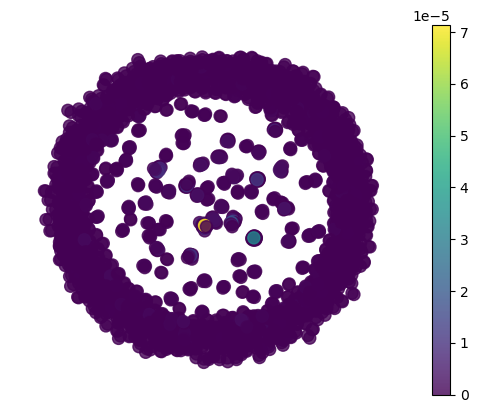

In [43]:
# similar pattern
# List of nodes to remove
#NB! Low degree vs high betweenness?? - Want to connect to one with high betweenness. 
#This runs fast so can do it on the whole sample, while the betweenees are more gready...


list_nodes =list(G_weighted.nodes())
list_nodes.reverse()   # for showing the nodes with high betweeness centrality 
pos = nx.spring_layout(G_weighted)
ec = nx.draw_networkx_edges(G_weighted, pos, alpha=0.1)
nc = nx.draw_networkx_nodes(G_weighted, pos, nodelist=list_nodes, node_color=[G_weighted.nodes[n]["betweenness"] for n in list_nodes], 
                            alpha=0.8, node_shape = '.')
plt.colorbar(nc)
plt.axis('off')
plt.show()

In [44]:
partition = community_louvain.best_partition(G_weighted)
# add it as an attribute to the nodes
for n in G_weighted.nodes:
    G_weighted.nodes[n]["louvain"] = partition[n]

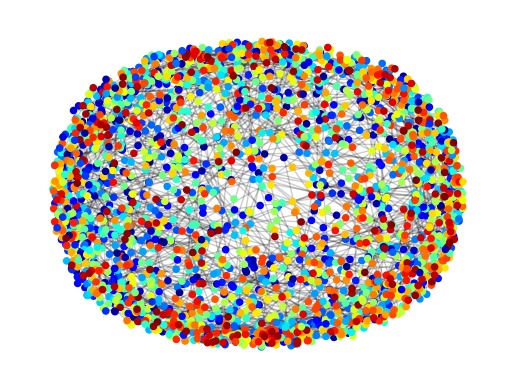

In [45]:
# plot it out
pos = nx.spring_layout(G_weighted,k=0.2)
ec = nx.draw_networkx_edges(G_weighted, pos, alpha=0.2)
nc = nx.draw_networkx_nodes(G_weighted, pos, nodelist=G_weighted.nodes(), node_color=[G_weighted.nodes[n]["louvain"] for n in G_weighted.nodes], 
                            node_size=20, cmap=plt.cm.jet)
plt.axis('off')
plt.show()

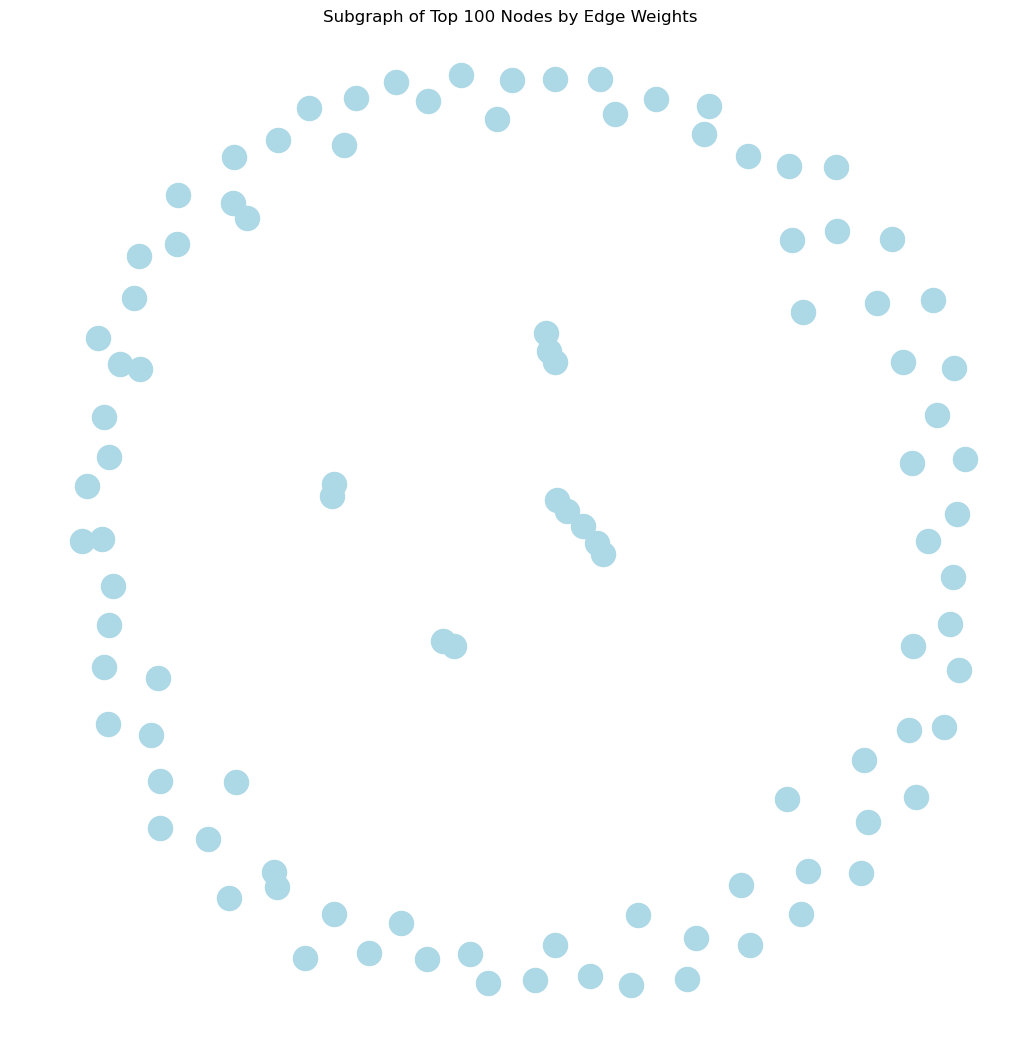

In [46]:
# Calculate the sum of weights for each node
node_weights = {node: sum(weight for _, _, weight in G_weighted.edges(node, data='weight')) for node in G_weighted.nodes()}

# Sort nodes by their weights and get the top 100
top_weight_nodes = sorted(node_weights.items(), key=operator.itemgetter(1), reverse=True)[:100]
top_weight_nodes = [node for node, _ in top_weight_nodes]

# Create a subgraph with these top nodes
subgraph_weights = G_weighted.subgraph(top_weight_nodes)

# Visualize the subgraph
plt.figure(figsize=(10, 10))
nx.draw(subgraph_weights, with_labels=None, node_color='lightblue', edge_color='gray')
plt.title("Subgraph of Top 100 Nodes by Edge Weights")
plt.show()

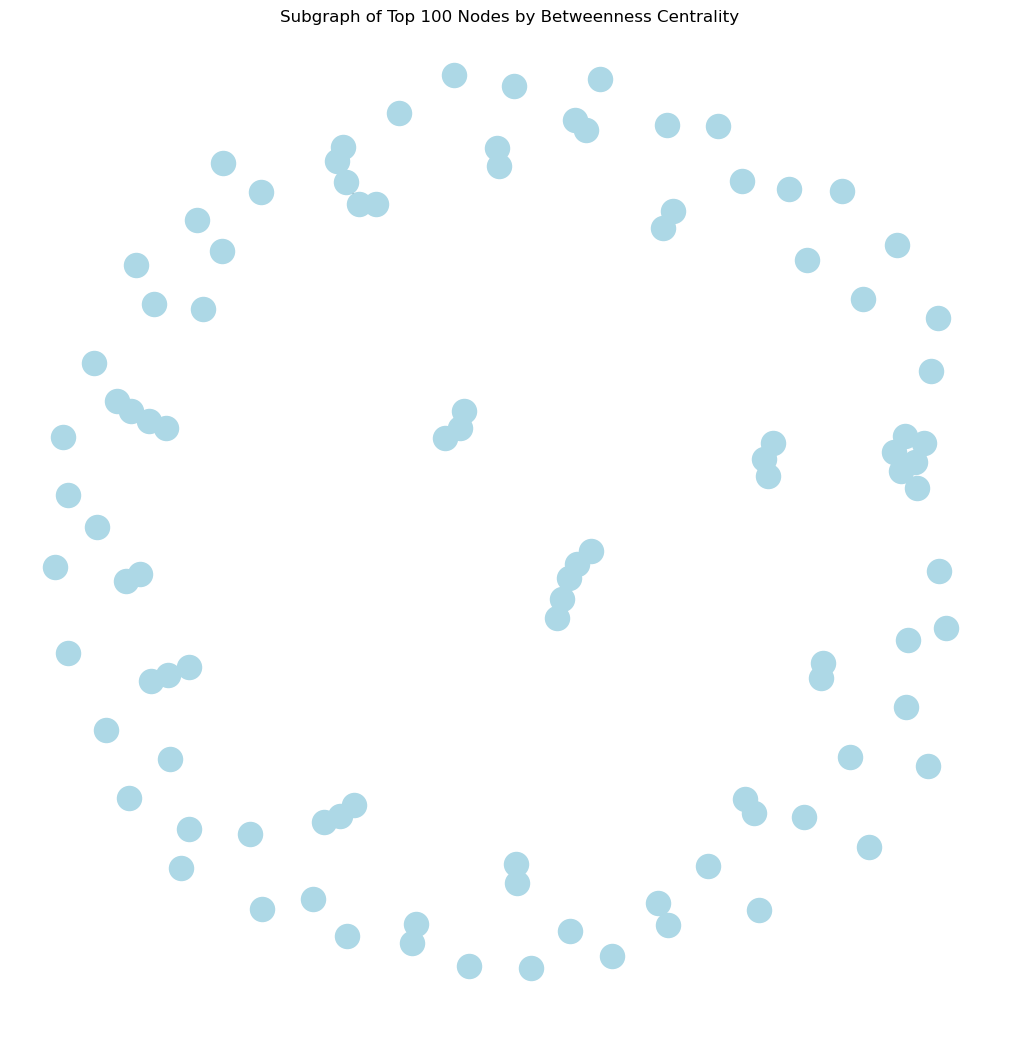

In [47]:
# Sort nodes by their betweenness centrality and get the top 100
top_betweenness_nodes = sorted(betweenness.items(), key=operator.itemgetter(1), reverse=True)[:100]
top_betweenness_nodes = [node for node, _ in top_betweenness_nodes]

# Create a subgraph with these top nodes
subgraph_betweenness = G_weighted.subgraph(top_betweenness_nodes)

# Visualize the subgraph
plt.figure(figsize=(10, 10))
nx.draw(subgraph_betweenness, with_labels=None, node_color='lightblue', edge_color='gray')
plt.title("Subgraph of Top 100 Nodes by Betweenness Centrality")
plt.show()

Try to bootstrapp, to reproduce network: 


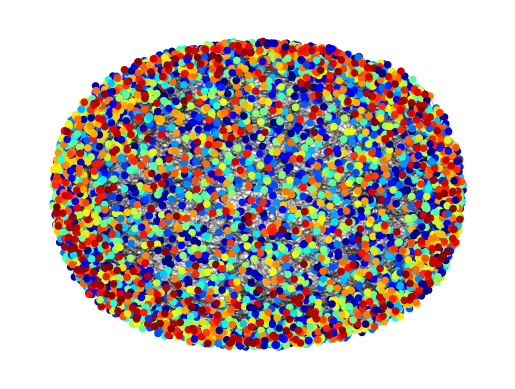

In [50]:

def bootstrap_edges(edges, n_bootstrap=100, sample_size=3000):
    """
    Generate n_bootstrap bootstrapped samples of the edge list.
    Each sample will be of size sample_size.
    """
    bootstrapped_samples = []
    for _ in range(n_bootstrap):
        sampled_edges = [random.choice(edges) for _ in range(sample_size)]
        bootstrapped_samples.append(sampled_edges)
    return bootstrapped_samples

# Assuming 'edges' is your original edge list
bootstrapped_edge_lists = bootstrap_edges(edges, n_bootstrap=100, sample_size=3000)

# Example: Creating a graph from the first bootstrapped sample
G_bootstrapped = nx.Graph()
G_bootstrapped.add_edges_from(bootstrapped_edge_lists[0])

partition = community_louvain.best_partition(G_bootstrapped)
# add it as an attribute to the nodes
for n in G_bootstrapped.nodes:
    G_bootstrapped.nodes[n]["louvain"] = partition[n]

# plot it out
pos = nx.spring_layout(G_bootstrapped,k=0.2)
ec = nx.draw_networkx_edges(G_bootstrapped, pos, alpha=0.2)
nc = nx.draw_networkx_nodes(G_bootstrapped, pos, nodelist=G_bootstrapped.nodes(), node_color=[G_bootstrapped.nodes[n]["louvain"] for n in G_bootstrapped.nodes], 
                            node_size=20, cmap=plt.cm.jet)
plt.axis('off')
plt.show()

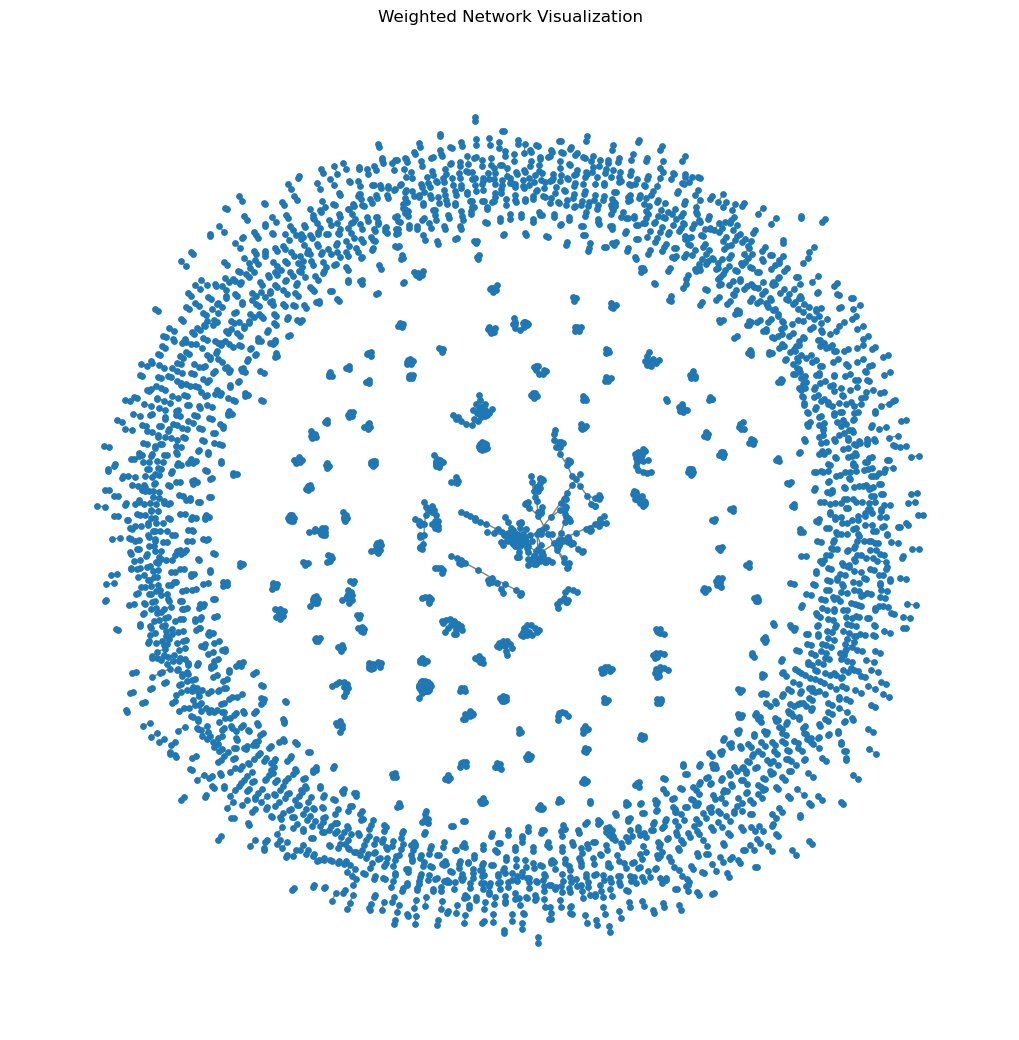

In [51]:
# Visualize the graph with edge widths based on weights
plt.figure(figsize=(10, 10))
nx.draw(G_bootstrapped, node_size=15, edge_color="gray", with_labels=False)
plt.title("Weighted Network Visualization")
plt.show()